# Neural Network
(C) 2018 Dariusz Kajtoch

In [8]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import sys
sys.path.append('../')
from incentives import optimal_revenue

In [5]:
data = pd.read_csv('../data/train.csv')

In [6]:
X = data[[
          'perc_premium_paid_by_cash_credit', 
#          'age_in_days', 
#          'Income', 
          'Count_3-6_months_late', 
          'Count_6-12_months_late', 
          'Count_more_than_12_months_late', 
          'no_of_premiums_paid', 
#          'premium',
          'application_underwriting_score',
#          'sourcing_channel'
         ]]
X['logIncome'] = np.log(data['Income'])
#X['logAge'] = np.log(data['age_in_days'])
#X['logperc_premium_paid_by_cash_credit'] = np.log(1. + data['perc_premium_paid_by_cash_credit'])
#X['standard_age'] = data['age_in_days'].apply(lambda row: np.floor(row/365.))
#X['perc'] = data['perc_premium_paid_by_cash_credit'].apply(lambda x: x if x<0.5 else x-1.)

from scipy.stats import boxcox

X['BCage_in_days'], _ = boxcox(data['age_in_days'])
#X['BCIncome'], _ = boxcox(data['Income'])

# fill nans
for name in X.columns.tolist():
    val = X[name].mean()#.iloc[0]
    X[name].fillna(val, inplace=True)
    
# predictor
y = data['renewal']

# premium
premium = data['premium']

In [13]:
# ---------------------------------------
import random as rn
import tensorflow as tf
np.random.seed(654)
rn.seed(654)
tf.set_random_seed(654)
import os
os.environ['PYTHONHASHSEED'] = '0'
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
# ---------------------------------------
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

# ----------------------------
# Define model
# ----------------------------
input_dim = len(X.columns)

model = Sequential()
model.add(Dense(32, input_dim=input_dim, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(16, kernel_initializer='random_uniform', activation='relu'))
#model.add(Dense(16, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# combine scaler with neural network
clf = Pipeline([('feature', StandardScaler()), ('model', model)])

# ----------------------
# Validate
# ----------------------

auc_tab  = np.array([])
loss_tab = np.array([])
revenue  = np.array([])

random_state = [245, 34, 78, 1234, 888]

for rstate in random_state:
    skf = StratifiedKFold(n_splits=10, random_state=rstate)
    
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        clf.fit(X_train, y_train,
            model__epochs=9,
            model__batch_size=200,
            model__verbose=False
        )
    
        prob = np.float64(clf.predict_proba(X_test))
        premium_test = premium.iloc[test_index]
    
        auc = roc_auc_score(y_test, prob)
        loss = log_loss(y_test, prob)
        net = np.array([optimal_revenue(premium_test.iloc[i], prob[i])[1] for i in range(0,len(prob))])
        net = np.sum(net)
    
        auc_tab  = np.append(auc_tab, auc)
        loss_tab = np.append(loss_tab, loss)
        revenue  = np.append(revenue, net)
    
        print('Single Fold done')

Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done


In [11]:
print('AUC: %.8f +/- %.8f' % (np.mean(auc_tab), np.std(auc_tab)))
print('Loss: %.8f +/- %.8f' % (np.mean(loss_tab), np.std(loss_tab)))

AUC: 0.84341855 +/- 0.00805440
Loss: 0.17904953 +/- 0.00318279


1. epochs = 10, batch_size = 200
    * AUC: 0.84377266 +/- 0.00832411
    * Loss: 0.17878962 +/- 0.00310919
2. epochs = 12, batch_size = 200
    * AUC: 0.84352481 +/- 0.00790659
    * Loss: 0.17875443 +/- 0.00312427
3. epochs = 12, batch_size = 190
    * AUC: 0.84228100 +/- 0.00934785
    * Loss: 0.17935454 +/- 0.00328438
4. epochs = 5, batch_size = 100
    * AUC: 0.84176712 +/- 0.00793250
    * Loss: 0.18011643 +/- 0.00283375
5. epochs = 9, batch_size = 200
    * AUC: 0.84412345 +/- 0.00794785
    * Loss: 0.17875216 +/- 0.00286832
6. epochs = 8, batch_size = 200
    * AUC: 0.84341855 +/- 0.00805440
    * Loss: 0.17904953 +/- 0.00318279

In [15]:
print(auc_tab)
print(loss_tab)
print(revenue)

[0.84555944 0.8448198  0.82838899 0.84716538 0.85696099 0.83564729
 0.84758103 0.85280989 0.84506113 0.83724055 0.85221493 0.85132033
 0.83561421 0.85443601 0.85958523 0.83767455 0.84940094 0.85537582
 0.84346422 0.83890975 0.85349065 0.85191651 0.83614347 0.85784972
 0.86029442 0.83840027 0.84966426 0.85543434 0.84596514 0.83769597
 0.85381499 0.85236388 0.83833249 0.85673885 0.86106278 0.83976687
 0.85273454 0.85580321 0.84919311 0.839689   0.85469209 0.85222883
 0.83826904 0.85899693 0.86065602 0.83846587 0.85268951 0.85637328
 0.8489069  0.84202553]
[0.17882975 0.17868529 0.18225348 0.1771114  0.17394089 0.18311193
 0.17762543 0.17484877 0.17952503 0.18158964 0.17523164 0.17572435
 0.17822879 0.17398667 0.17225878 0.18255741 0.17587981 0.1738454
 0.17906608 0.18084446 0.17488192 0.17524457 0.17767335 0.17258693
 0.17188057 0.18285396 0.17512902 0.17389772 0.17787167 0.18109717
 0.17499198 0.17510019 0.17756394 0.17362696 0.1717565  0.18171956
 0.17377644 0.17340235 0.17686024 0.180

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

plt.rcParams['text.usetex'] = True

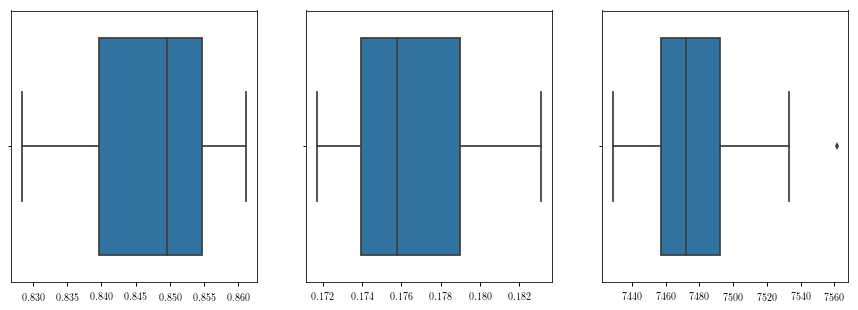

In [20]:
plt.close()

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3)

sns.boxplot(auc_tab, ax=ax[0])
sns.boxplot(loss_tab, ax=ax[1])
sns.boxplot(revenue, ax=ax[2])